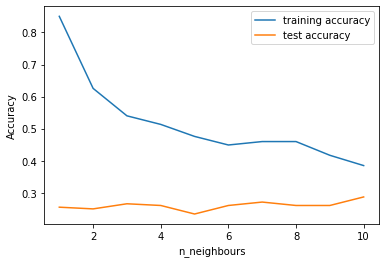

In [12]:
import pandas as pd
import numpy as np
import psycopg2
import configparser
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
%matplotlib inline 

#return a salary range
def get_pkg_range(package):
    lower = (int((package)/10000))*10
    upper = lower+10
    return (str(lower) + " - " + str(upper))

config = configparser.ConfigParser()
config.read('app.ini')
db_params = config['DB']
app_params = config['APP']

#load data from SQL
con = psycopg2.connect(host='localhost', database=db_params['db'], user = db_params['user'], password = db_params['password'] )
sql = "SELECT * from %s" % (db_params['table'])
client_df = pd.read_sql_query(sql, con)
client_df['annual_salary_fte'] = client_df[app_params['actual_salary_column']] * (int(app_params['fte_hours']) / client_df[app_params['weekly_hours_column']])

client_df['total_annual_pkg'] = client_df[app_params['actual_salary_column']]

if ('benefits_column_list' in app_params):
    benefit_colmuns = app_params['benefits_column_list'].split(',')
    benefit_colmuns = [s.strip() for s in benefit_colmuns]
    for benefit_column in benefit_colmuns:
        client_df['total_annual_pkg'] += client_df[benefit_column]

client_df['total_annual_pkg_fte'] = client_df['total_annual_pkg'] * (int(app_params['fte_hours']) / client_df[app_params['weekly_hours_column']])

client_df['total_annual_pkg_fte_range'] = client_df['total_annual_pkg_fte'].apply(get_pkg_range)

features = app_params['feature_list'].split(',')
features = [s.strip() for s in features]

model_columns = features.copy()
model_columns.extend(['total_annual_pkg_fte_range'])
df = client_df[model_columns]

X = df.drop('total_annual_pkg_fte_range', axis=1)

try:
    X = X.drop('age', axis=1)
    use_age = True
except:
    use_age = False
    print('Age not a feature')

y = df['total_annual_pkg_fte_range']

X = pd.get_dummies(data=X, drop_first=True)

if use_age:
    X['age'] = client_df['age']

#needed
#scaler = StandardScaler()
#X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,  random_state=0)

training_accuracy = []
test_accuracy = []

neighbors_settings = range(1,11)

for num_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors = num_neighbors)
    #clf = KNeighborsClassifier(n_neighbors = num_neighbors, weights='distance')
    clf.fit(X_train, y_train)
    training_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label = 'training accuracy')
plt.plot(neighbors_settings, test_accuracy, label = 'test accuracy')
plt.ylabel("Accuracy")
plt.xlabel("n_neighbours")
plt.legend()
plt.show()

In [14]:
clf = KNeighborsClassifier(n_neighbors=2)
clf.fit(X_train, y_train)

data = np.array([0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,40])
prediction = clf.predict(data.reshape(1,-1))
print(prediction)


['60 - 70']


In [13]:
rf = RandomForestClassifier(n_estimators=10000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("perf on RF\n{}".format(metrics.classification_report(y_pred, y_test)))



perf on RF
              precision    recall  f1-score   support

     10 - 20       0.75      0.75      0.75         4
   100 - 110       0.20      0.18      0.19        11
   110 - 120       0.57      0.33      0.42        12
   120 - 130       0.00      0.00      0.00         1
   130 - 140       0.00      0.00      0.00         0
   140 - 150       0.00      0.00      0.00         1
   150 - 160       0.00      0.00      0.00         1
   160 - 170       0.00      0.00      0.00         0
   170 - 180       0.00      0.00      0.00         0
   180 - 190       0.00      0.00      0.00         0
   190 - 200       0.00      0.00      0.00         2
     20 - 30       0.71      0.52      0.60        23
   200 - 210       0.00      0.00      0.00         0
   210 - 220       0.00      0.00      0.00         0
   250 - 260       0.00      0.00      0.00         1
   280 - 290       0.00      0.00      0.00         0
     30 - 40       0.47      0.50      0.48        44
     40 - 50    